In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from dotenv import load_dotenv
from transformers import logging
logging.set_verbosity_error()
from bert_score import score
from scipy.stats import mannwhitneyu
import itertools

# 1. LLM-as-a-Judge

In [2]:
original_t5 = pd.read_csv('data/original_t5_summary.csv')
ft_t5 = pd.read_csv("data/fine_tune_t5_summary.csv")
llama3 = pd.read_csv("data/llama_agent_summary.csv")

In [3]:
original_t5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_long                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_tiny                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [4]:
ft_t5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_tiny                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_long                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [5]:
llama3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   folder_path                    97 non-null     object
 1   combined_cleaned_whisper_text  97 non-null     object
 2   named_entities                 97 non-null     object
 3   summary_long                   97 non-null     object
 4   summary_short                  97 non-null     object
 5   summary_tiny                   97 non-null     object
dtypes: object(6)
memory usage: 4.7+ KB


In [7]:
# load llama 3
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_TOKEN")
login(hf_token)

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             torch_dtype=torch.float16, 
                                             device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


In [8]:
def llm(prompt, max_new_tokens=512, temperature=0.4):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if prompt in decoded:
        return decoded[len(prompt):].strip()
    return decoded.strip()

In [9]:
# evaluation prompt
def generate_prompt(original, summary, summary_type):
    return f"""<|system|>
You are a helpful and precise assistant that evaluates summaries for quality and accuracy.
<|user|>
Please evaluate the following {summary_type} summary of the original text based on four aspects:

1. Fluency – Grammar and readability
2. Coverage – Inclusion of all important points
3. Coherence – Logical flow and structure
4. Faithfulness – Accuracy and factual consistency with the original

Rate each aspect using a number from 1 to 5 based on the following scale:
1 = Much worse, 2 = Somewhat worse, 3 = About the same, 4 = Somewhat better, 5 = Much better

Return your assessment in this **exact format**, using numbers only:
Fluency: [number]  
Coverage: [number]  
Coherence: [number]  
Faithfulness: [number]  
Comment: [brief explanation in one or two sentences]

Original text:
\"\"\"{original}\"\"\"

Summary to evaluate:
\"\"\"{summary}\"\"\"
<|assistant|>
"""

def extract_after_assistant_tag(text):
    if "<|assistant|>" in text:
        return text.split("<|assistant|>", 1)[1].strip()
    return text.strip()

def extract_score(line, expected_label):
    line = line.strip()
    if line.startswith(f"{expected_label}:"):
        match = re.search(rf"{expected_label}:\s*([1-5])\b", line)
        if match:
            return int(match.group(1))
    return None

In [ ]:
# evaluate original T5

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(original_t5.iterrows(), total=len(original_t5)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())


In [46]:
original_t5 = original_t5.assign(**results)

original_t5.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...",mr quilter is the apostle of the middle classe...,mr quilter is the apostle of the middle classe...,mr quilter is the apostle of the middle classe...,2,2,1,1,...,2,2,2,2,The summary lacks proper grammar and readabili...,2,1,2,1,The summary is quite short and lacks coherence...
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...",calico calago hesitated but if we look sharp w...,calico calago hesitated but if we look sharp w...,calico calago hesitated but if we look sharp w...,2,2,2,1,...,4,2,4,3,"The summary is mostly clear and concise, but i...",4,2,4,2,"The summary is concise but lacks clarity, maki..."
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...",irohg briann saw something close to panic on h...,irohg briann saw something close to panic on h...,irohg briann saw something close to panic on h...,2,2,2,1,...,2,1,2,1,"The summary lacks clarity and coherence, and i...",3,2,3,2,"The summary is somewhat readable, but lacks de..."
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...",mr bartley alexander the playwright gave main ...,mr bartley alexander the playwright gave main ...,mr bartley alexander the playwright gave main ...,2,2,2,1,...,4,2,3,2,"The summary is somewhat concise, but it lacks ...",2,1,2,1,"The summary is very short and lacks context, m..."
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",the last two days of the voyage bartley found ...,the last two days of the voyage bartley found ...,the last two days of the voyage bartley found ...,2,1,1,1,...,4,2,3,2,The summary is somewhat better in terms of flu...,5,2,4,2,The summary is concise but lacks detail and co...


In [10]:
# evaluate fine-tuned T5

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(ft_t5.iterrows(), total=len(ft_t5)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())

100%|██████████| 97/97 [24:47<00:00, 15.34s/it]


In [11]:
ft_t5 = ft_t5.assign(**results)

ft_t5.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_tiny,summary_short,summary_long,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...",Mr. Quilter is the apostle of the middle class...,Mr. Quilter is the apostle of the middle class...,"Mr. Quilter, an advocate for the middle class,...",4,2,3,2,...,2,2,2,1,"The summary lacks fluency, with sentences that...",2,1,2,1,"The summary lacks clarity and is quite vague, ..."
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...","The king is flooded with disgrace, and his fri...",Poroshaegi sits in the room beside the dragon ...,"Polychrome, an advocate for the middle class, ...",4,2,3,2,...,4,2,4,3,"The summary is mostly accurate, but it lacks i...",2,1,2,1,"The summary lacks fluency and coherence, as it..."
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...",A man said to the universe sir i exist sweatco...,The brians' body trickled into the titling cla...,"Sir, a sweat-covered brians body trickled into...",2,3,2,1,...,4,2,4,2,The summary is somewhat better in terms of flu...,5,2,5,4,"The summary is concise and well-written, but i..."
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...","Alexander writes books, history of dancing, co...",The scene was underway in a cabin in the south...,"Alexander, an advocate for the middle class, h...",3,2,2,2,...,4,2,3,2,"The summary lacks fluency, with some sentences...",2,1,1,1,"The summary lacks fluency and coherence, as it..."
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",Alexander's luggage was sent to the savoy and ...,The last two days of the voyage Bartley found ...,Alexander Bartley arrived at Houston at half p...,2,2,2,1,...,4,2,4,3,The summary is well-written and easy to follow...,2,1,2,1,The summary is somewhat worse in terms of flue...


In [61]:
# evaluate llama 3 agents

# Results dict
results = {
    "fluency_long": [], "coverage_long": [], "coherence_long": [], "faithfulness_long": [], "comment_long": [],
    "fluency_short": [], "coverage_short": [], "coherence_short": [], "faithfulness_short": [], "comment_short": [],
    "fluency_tiny": [], "coverage_tiny": [], "coherence_tiny": [], "faithfulness_tiny": [], "comment_tiny": [],
}

# Loop through rows and evaluate summaries
for i, row in tqdm(llama3.iterrows(), total=len(llama3)):
    for typ in ["long", "short", "tiny"]:
        summary = row[f"summary_{typ}"]
        prompt = generate_prompt(row["combined_cleaned_whisper_text"], summary, typ)

        raw_output = llm(prompt)
        assistant_output = extract_after_assistant_tag(raw_output)
        lines = assistant_output.splitlines()

        for line in lines:
            if line.startswith("Fluency:"):
                results[f"fluency_{typ}"].append(extract_score(line, "Fluency"))
            elif line.startswith("Coverage:"):
                results[f"coverage_{typ}"].append(extract_score(line, "Coverage"))
            elif line.startswith("Coherence:"):
                results[f"coherence_{typ}"].append(extract_score(line, "Coherence"))
            elif line.startswith("Faithfulness:"):
                results[f"faithfulness_{typ}"].append(extract_score(line, "Faithfulness"))
            elif line.startswith("Comment:"):
                results[f"comment_{typ}"].append(line.replace("Comment:", "").strip())

100%|██████████| 97/97 [27:27<00:00, 16.98s/it]


In [62]:
llama3 = llama3.assign(**results)

llama3.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny,fluency_long,coverage_long,coherence_long,faithfulness_long,...,fluency_short,coverage_short,coherence_short,faithfulness_short,comment_short,fluency_tiny,coverage_tiny,coherence_tiny,faithfulness_tiny,comment_tiny
0,1272/128104,mr quilter is the apostle of the middle classe...,"[('quilter', 'PERSON'), ('quilters', 'PERSON')...","Mr. Quilter, an apostle of the middle classes,...","Mr. Quilter, an apostle of the middle class, s...",Mr. Quilter's article discusses the flaws in S...,4,4,4,4,...,5,4,5,4,The summary effectively conveys the main point...,4,2,4,3,The summary is generally well-written and easy...
1,1272/135031,because you were sleeping instead of conquerin...,"[('poroshaegi', 'PERSON'), ('dove', 'PERSON'),...","Polychrome, who had been watching from the roo...","Polychrome, who had been watching from the sha...","Calico Calago, disguised as the king, discover...",4,4,4,4,...,5,4,5,4,The summary is well-written and easy to follow...,4,2,4,3,The summary is generally well-written and easy...
2,1272/141231,a man said to the universe sir i exist sweatco...,"[('brians', 'NORP'), ('thousands', 'CARDINAL')...","A man, sweat-covered and injured, lay in a tit...","A man, Brienne, was in a state of reverie, his...","As Brienne, a skilled fencer, fights in the S,...",4,4,4,4,...,4,3,4,4,"The summary is clear and concise, but it omits...",4,2,4,3,The summary is well-written and easy to unders...
3,1462/170138,he had written a number of books himself among...,"[('shakespeare', 'PERSON'), ('ernest dousen', ...","Hughes, a playwright, has written a delightful...","Alexander, a playwright, attended a play featu...","Alexander, a playwright, attends a play featur...",4,4,4,4,...,4,3,4,4,The summary is well-written and easy to follow...,5,2,4,4,The summary is well-written and easy to follow...
4,1462/170142,the last two days of the voyage bartley found ...,"[('the last two days', 'DATE'), ('bartley', 'P...",Alexander's arrival at the Savoy Hotel marked ...,"Alexander and Hilda, reunited after two days, ...","Alexander and Hilda, reunited after years apar...",4,4,4,4,...,5,4,5,4,The summary effectively conveys the emotional ...,5,4,5,4,The summary accurately captures the essence of...


# 2. BERTScore

In [10]:
models = {
    'Original T5': original_t5,
    'Fine-Tuned T5': ft_t5,
    'Llama 3 Agents': llama3
}
types = ['long', 'short', 'tiny']

bertscore_results = {
    'Original T5': {},
    'Fine-Tuned T5': {},
    'Llama 3 Agents': {}
}

for model_name, df in models.items():
    for summary_type in types:
        candidates = df[f'summary_{summary_type}'].astype(str).tolist()
        references = df['combined_cleaned_whisper_text'].astype(str).tolist()
        
        P, R, F1 = score(candidates, references, lang='en', verbose=False)
        
        # use mean F1 score
        mean_f1 = F1.mean().item()
        bertscore_results[model_name][summary_type] = mean_f1
        
        df[f'bert_{summary_type}'] = F1.tolist()

In [ ]:
original_t5.to_csv("data/original_t5_summary_scores.csv", index = False)
ft_t5.to_csv("data/fine_tune_t5_summary_scores.csv", index = False)
llama3.to_csv("data/llama_agent_summary_scores.csv", index = False)

# 3. Scores Analysis

In [ ]:
original_t5_scores = pd.read_csv('data/original_t5_summary_scores.csv')
ft_t5_scores = pd.read_csv("data/fine_tune_t5_summary_scores.csv")
llama3_scores = pd.read_csv("data/llama_agent_summary_scores.csv")

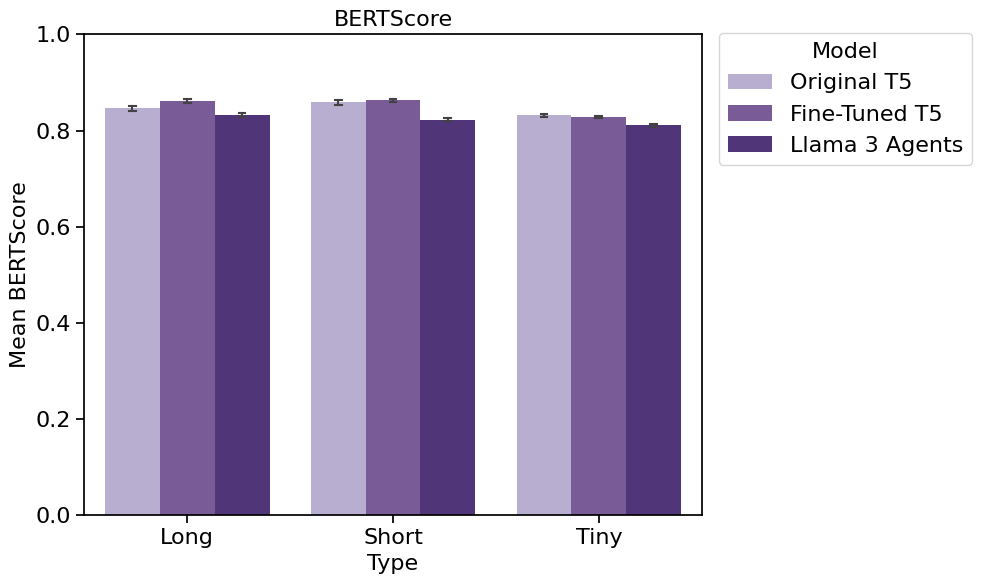

In [38]:
models = {
    'Original T5': original_t5_scores,
    'Fine-Tuned T5': ft_t5_scores,
    'Llama 3 Agents': llama3_scores
}
types = ['long', 'short', 'tiny']
custom_palette = {
    'Original T5': '#b4a8d6',
    'Fine-Tuned T5': '#7951a1',
    'Llama 3 Agents': '#4E2A84'
}

data = []
for model_name, df in models.items():
    for summary_type in types:
        for val in df[f'bert_{summary_type}']:
            data.append({
                'Model': model_name,
                'Type': summary_type.capitalize(),
                'BERT Score': val
            })

df_plot = pd.DataFrame(data)

sns.set_context("notebook")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_plot,
    x='Type', y='BERT Score', hue='Model',
    palette=custom_palette,
    errorbar=('ci', 95),
    capsize=0.1,
    err_kws={'linewidth': 1.5}
)

plt.title('BERTScore', fontsize=16)
plt.xlabel('Type', fontsize=16)
plt.ylabel('Mean BERTScore', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(
    title='Model',
    fontsize=16,
    title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.01, 1.025)
)

plt.tight_layout()
plt.show()

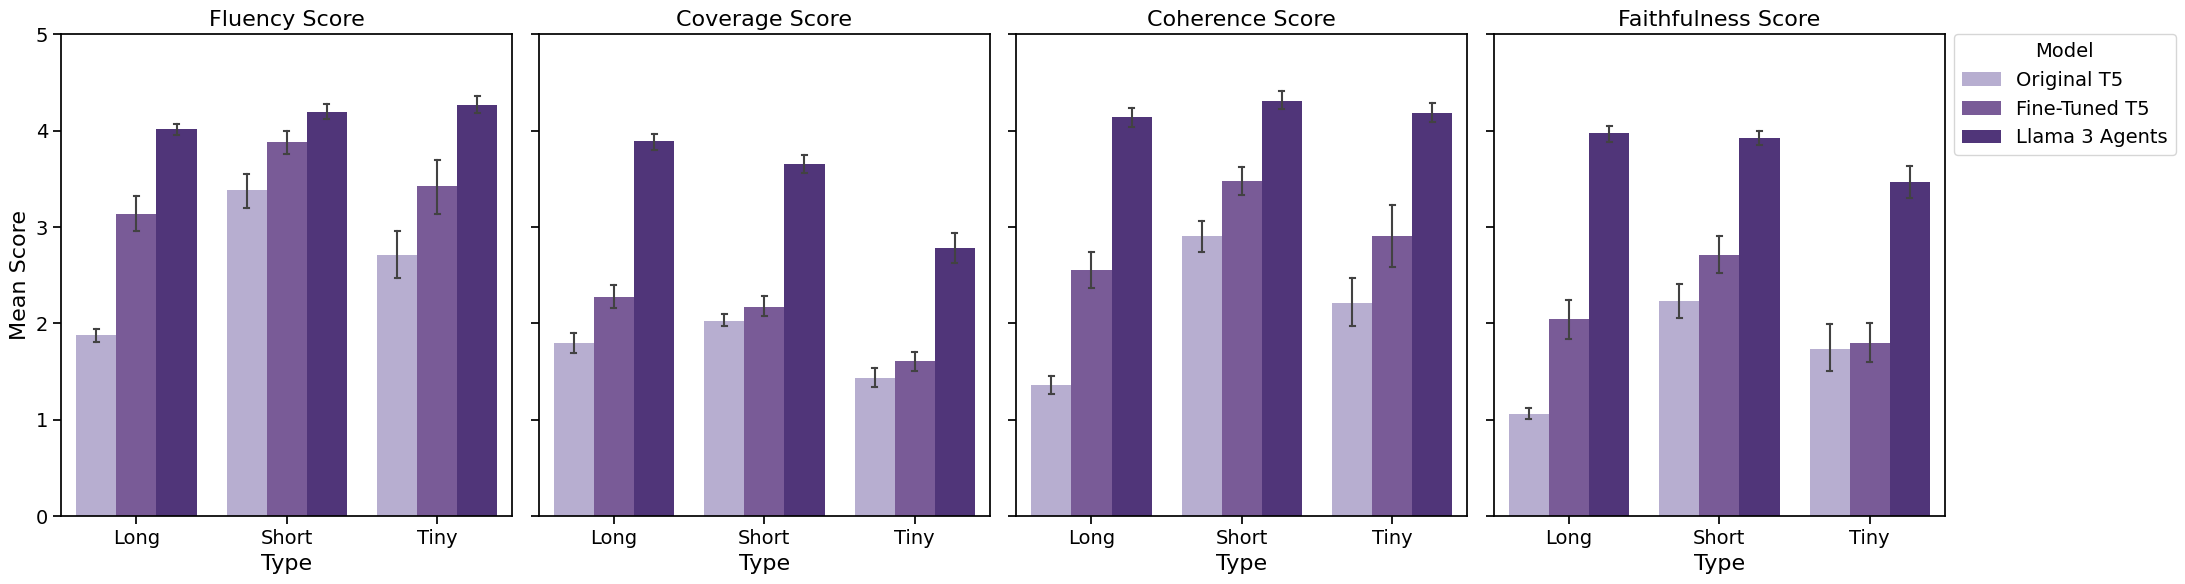

In [39]:
score_keys = [
    ('fluency', 'Fluency Score'),
    ('coverage', 'Coverage Score'),
    ('coherence', 'Coherence Score'),
    ('faithfulness', 'Faithfulness Score')
]

sns.set_context("notebook")

fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharey=True)

for ax, (score_key, score_label) in zip(axes, score_keys):
    data = []
    for model_name, df in models.items():
        for summary_type in types:
            values = df[f'{score_key}_{summary_type}']
            for val in values:
                data.append({
                    'Model': model_name,
                    'Type': summary_type.capitalize(),
                    'Score': val
                })
    df_plot = pd.DataFrame(data)

    sns.barplot(
        data=df_plot, x='Type', y='Score', hue='Model',
        palette=custom_palette, ax=ax, errorbar=('ci', 95),
        capsize=0.1, err_kws={'linewidth': 1.5}
    )

    ax.set_title(f'{score_label}', fontsize=16)
    ax.set_xlabel('Type', fontsize=16)
    if ax == axes[0]:
        ax.set_ylabel('Mean Score', fontsize=16)
    else:
        ax.set_ylabel('')
    ax.set_ylim(0, 5)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    if ax != axes[-1]:
        ax.get_legend().remove()
    else:
        legend = ax.legend(
            title='Model',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            borderaxespad=0.,
            fontsize=14,
            title_fontsize=14
        )

plt.tight_layout()
plt.show()


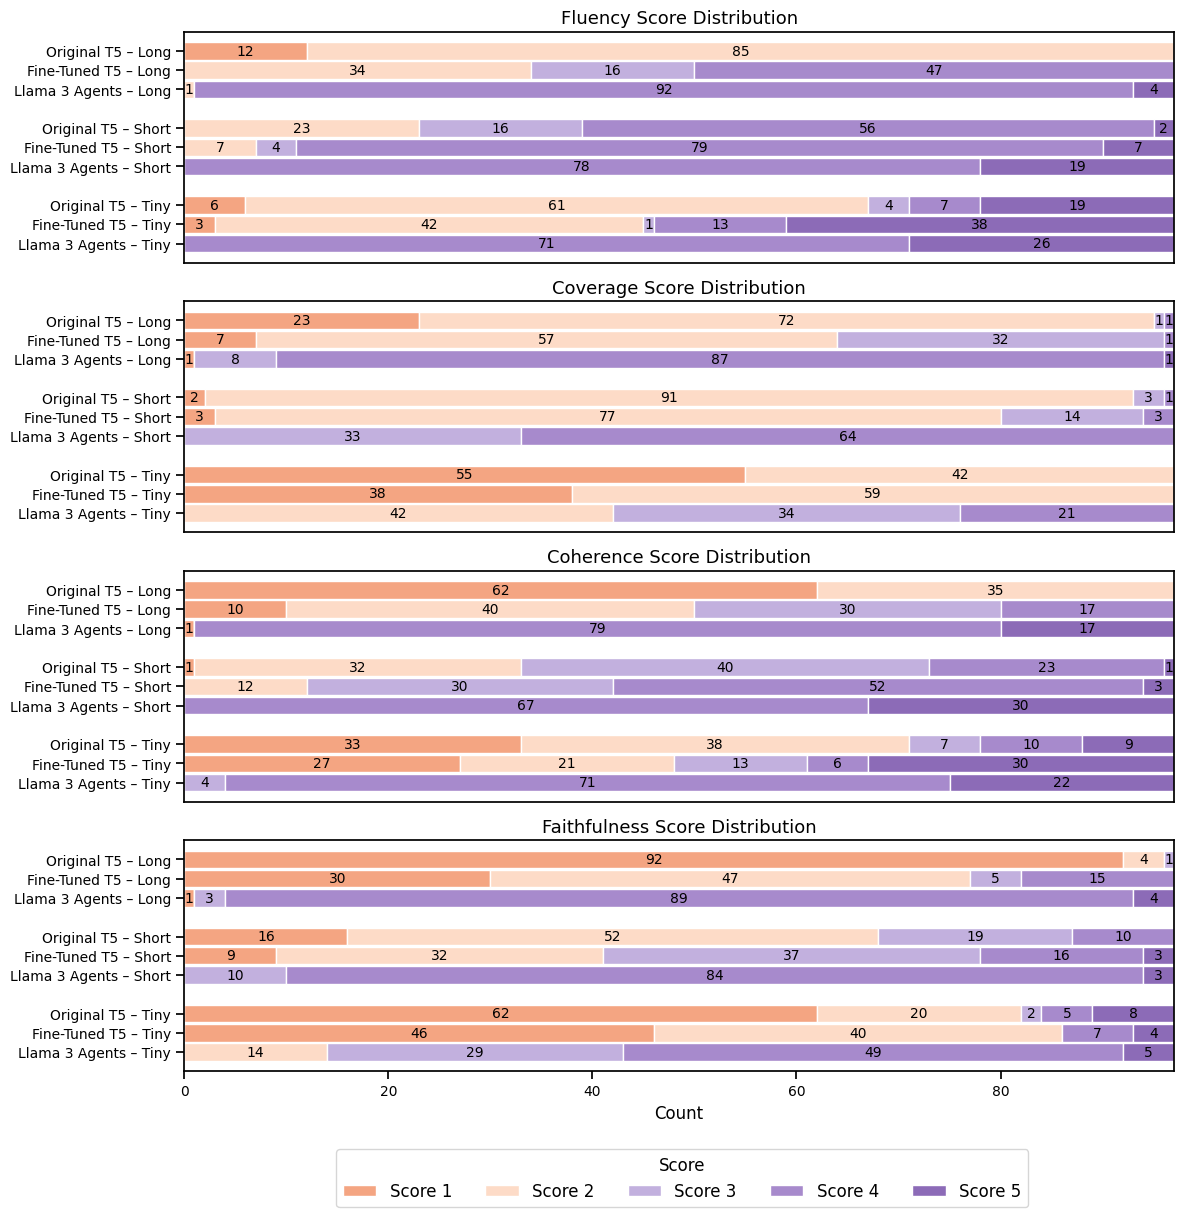

In [40]:
models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}

summary_types = ["long", "short", "tiny"]
dimensions = ["fluency", "coverage", "coherence", "faithfulness"]
score_range = [1, 2, 3, 4, 5]

data = {dim.capitalize(): {stype.capitalize(): [] for stype in summary_types} for dim in dimensions}

for dim in dimensions:
    for stype in summary_types:
        for model_name, df in models.items():
            col = f"{dim}_{stype}"
            counts = df[col].value_counts().reindex(score_range, fill_value=0).tolist()
            data[dim.capitalize()][stype.capitalize()].append(counts)

colors = ['#f4a582', '#fddbc7', '#c2b0de', '#a78acc', '#8c6bb7']
score_labels = ['Score 1', 'Score 2', 'Score 3', 'Score 4', 'Score 5']
model_names = list(models.keys())
summary_types_cap = ['Long', 'Short', 'Tiny']
dimensions_cap = list(data.keys())

max_total = 97
fig, axes = plt.subplots(nrows=len(dimensions_cap), figsize=(12, 12), sharex=True)

for plot_idx, dimension in enumerate(dimensions_cap):
    ax = axes[plot_idx]
    bar_height = 0.25
    yticks = []
    ylabels = []

    for i, stype in enumerate(summary_types_cap):
        for j in range(len(model_names)):
            y = i + j * bar_height
            values = data[dimension][stype][j]
            left = 0
            for k in range(5):  # Score levels
                width = values[k]
                ax.barh(y, width, left=left, height=bar_height * 0.9, color=colors[k], edgecolor='white')
                if width > 0:
                    ax.text(left + width / 2, y, str(width), ha='center', va='center', fontsize=10)
                left += width
            yticks.append(y)
            ylabels.append(f"{model_names[j]} – {stype}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=10)
    ax.set_xlim(0, max_total)
    ax.invert_yaxis()
    ax.set_title(f"{dimension} Score Distribution", fontsize=13)

    if plot_idx == len(dimensions_cap) - 1:
        ax.set_xlabel("Count", fontsize=12)
        ax.tick_params(axis='x', labelsize=10)
    else:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)

fig.legend(score_labels, title="Score", loc='lower left', ncol=5, bbox_to_anchor=(0.28, -0.02), fontsize=12)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()


In [41]:
def compare_all_scores(models, metrics, types=['long', 'short', 'tiny'], alpha=0.05):
    results = []
    model_names = list(models.keys())
    
    for metric in metrics:
        for summary_type in types:
            col = f"{metric}_{summary_type}"
            for model_a, model_b in itertools.combinations(model_names, 2):
                scores_a = models[model_a][col]
                scores_b = models[model_b][col]
                # Test if A > B
                stat, pval_greater = mannwhitneyu(scores_a, scores_b, alternative='greater')
                # Test if B > A
                stat, pval_less = mannwhitneyu(scores_a, scores_b, alternative='less')
                results.append({
                    "Metric": metric.capitalize(),
                    "Type": summary_type.capitalize(),
                    "Model A": model_a,
                    "Model B": model_b,
                    "A > B p-value": pval_greater,
                    "B > A p-value": pval_less,
                    "A mean": scores_a.mean(),
                    "B mean": scores_b.mean(),
                    "A median": scores_a.median(),
                    "B median": scores_b.median(),
                    "A > B significant": pval_greater < alpha,
                    "B > A significant": pval_less < alpha
                })
    df_results = pd.DataFrame(results)
    return df_results

models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}
metrics = ['fluency', 'coverage', 'coherence', 'faithfulness']

results_df = compare_all_scores(models, metrics)
results_df

,Metric,Type,Model A,Model B,A > B p-value,B > A p-value,A mean,B mean,A median,B median,A > B significant,B > A significant
0,Fluency,Long,Original T5,Fine-Tuned T5,1.000000,4.109636e-22,1.876289,3.134021,2.0,3.0,False,True
1,Fluency,Long,Original T5,Llama 3 Agents,1.000000,1.537875e-40,1.876289,4.020619,2.0,4.0,False,True
2,Fluency,Long,Fine-Tuned T5,Llama 3 Agents,1.000000,8.633055e-16,3.134021,4.020619,3.0,4.0,False,True
3,Fluency,Short,Original T5,Fine-Tuned T5,0.999998,1.949773e-06,3.381443,3.886598,4.0,4.0,False,True
4,Fluency,Short,Original T5,Llama 3 Agents,1.000000,1.042430e-13,3.381443,4.195876,4.0,4.0,False,True
5,Fluency,Short,Fine-Tuned T5,Llama 3 Agents,0.999923,7.857203e-05,3.886598,4.195876,4.0,4.0,False,True
6,Fluency,Tiny,Original T5,Fine-Tuned T5,0.999641,3.626527e-04,2.711340,3.422680,2.0,4.0,False,True
7,Fluency,Tiny,Original T5,Llama 3 Agents,1.000000,4.760057e-15,2.711340,4.268041,2.0,4.0,False,True
8,Fluency,Tiny,Fine-Tuned T5,Llama 3 Agents,0.998002,2.015719e-03,3.422680,4.268041,4.0,4.0,False,True
9,Coverage,Long,Original T5,Fine-Tuned T5,1.000000,3.497641e-09,1.793814,2.278351,2.0,2.0,False,True


In [47]:
def compare_scores_aggregated(models, metrics, types=['long', 'short', 'tiny'], alpha=0.05):
    results = []
    model_names = list(models.keys())
    for metric in metrics:
        # For each model, concatenate all summary types for this metric
        model_scores = {
            model_name: pd.concat([
                df[f'{metric}_{summary_type}'].dropna() for summary_type in types
            ], ignore_index=True)
            for model_name, df in models.items()
        }
        for model_a, model_b in itertools.combinations(model_names, 2):
            scores_a = model_scores[model_a]
            scores_b = model_scores[model_b]
            # Test if A > B
            stat, pval_greater = mannwhitneyu(scores_a, scores_b, alternative='greater')
            # Test if B > A
            stat, pval_less = mannwhitneyu(scores_a, scores_b, alternative='less')
            results.append({
                "Metric": metric.capitalize(),
                "Model A": model_a,
                "Model B": model_b,
                "A > B p-value": pval_greater,
                "B > A p-value": pval_less,
                "A mean": scores_a.mean(),
                "B mean": scores_b.mean(),
                "A median": scores_a.median(),
                "B median": scores_b.median(),
                "A > B significant": pval_greater < alpha,
                "B > A significant": pval_less < alpha
            })
    df_results = pd.DataFrame(results)
    numeric_cols = [
        "A mean", "B mean",
        "A median", "B median"
    ]
    df_results[numeric_cols] = df_results[numeric_cols].round(4)
    return df_results

models = {
    "Original T5": original_t5_scores,
    "Fine-Tuned T5": ft_t5_scores,
    "Llama 3 Agents": llama3_scores
}
metrics = ['fluency', 'coverage', 'coherence', 'faithfulness']

results_df = compare_scores_aggregated(models, metrics)
results_df

,Metric,Model A,Model B,A > B p-value,B > A p-value,A mean,B mean,A median,B median,A > B significant,B > A significant
0,Fluency,Original T5,Fine-Tuned T5,1.0,1.057953e-17,2.6564,3.4811,2.0,4.0,False,True
1,Fluency,Original T5,Llama 3 Agents,1.0,1.068750e-55,2.6564,4.1615,2.0,4.0,False,True
2,Fluency,Fine-Tuned T5,Llama 3 Agents,1.0,2.764822e-15,3.4811,4.1615,4.0,4.0,False,True
3,Coverage,Original T5,Fine-Tuned T5,1.0,1.659052e-08,1.7526,2.0206,2.0,2.0,False,True
4,Coverage,Original T5,Llama 3 Agents,1.0,1.026022e-83,1.7526,3.4467,2.0,4.0,False,True
5,Coverage,Fine-Tuned T5,Llama 3 Agents,1.0,1.304788e-68,2.0206,3.4467,2.0,4.0,False,True
6,Coherence,Original T5,Fine-Tuned T5,1.0,3.017125e-16,2.1615,2.9794,2.0,3.0,False,True
7,Coherence,Original T5,Llama 3 Agents,1.0,1.055738e-76,2.1615,4.2131,2.0,4.0,False,True
8,Coherence,Fine-Tuned T5,Llama 3 Agents,1.0,1.326584e-40,2.9794,4.2131,3.0,4.0,False,True
9,Faithfulness,Original T5,Fine-Tuned T5,1.0,5.278079e-12,1.6770,2.1856,1.0,2.0,False,True
